This notebook explores the SDSS-MGS observational sample.

* Target selection: https://www.sdss3.org/dr8/algorithms/target_selection.php
* Data Release: https://arxiv.org/abs/0812.0649
* NYU Value-Added Catalog: http://sdss.physics.nyu.edu/vagc/
* Power spectrum analysis: https://arxiv.org/abs/astro-ph/0608636

In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import matplotlib.pyplot as plt
from os.path import join as pjoin

import astropy
from astropy.io import fits
import h5py
import pandas as pd

from scipy.spatial import ConvexHull

## Load data

In [2]:
wdir = '../MGS'
# os.listdir(wdir)

In [3]:
# Load VAGC
with fits.open(pjoin(wdir, 'lss_index.dr72.fits')) as f:
    print(f.info())
    data = f[1].data

print(data.dtype.names)

# Load Tjitske's data

cols = ['RA', 'DEC', 'Z', 'MAG', 'SURVEY', 'ZSRC']
with h5py.File(pjoin(wdir, 'tinker_SDSS_centrals_M9.7.valueadd.hdf5'), 'r') as f:
    datatj = pd.DataFrame([f[col] for col in cols], index=cols).T

Filename: ../MGS/lss_index.dr72.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      10   ()      
  1                1 BinTableHDU     43   2506754R x 13C   [D, D, E, J, J, E, J, J, E, E, J, J, J]   
None
('RA', 'DEC', 'Z', 'ZTYPE', 'SECTOR', 'FGOTMAIN', 'QUALITY', 'ISBAD', 'M', 'MMAX', 'ILSS', 'ICOMB', 'VAGC_SELECT')


## Calculate other fields

In [4]:
rae = 100, 270
dece = 0, 70
ze = 0.01, 0.4
def in_range(data):
    mask = (rae[0] < data['RA']) & (data['RA'] < rae[1]) & (dece[0] < data['DEC']) & (data['DEC'] < dece[1])
    mask &= (ze[0] <= data['Z']) & (data['Z'] < ze[1])
    return mask


# mask vagc
print(len(data))
mask = (data['ILSS'] != -1) & (data['VAGC_SELECT'] == 7)
data = data[mask]

mask = in_range(data)
data = data[mask]

data = pd.DataFrame(np.array([data[col] for col in data.dtype.names]).T, columns=data.dtype.names)
print(len(data))

# mask tjitske
print(len(datatj))
mask = in_range(datatj)
datatj = datatj[mask]

for col in ['RA' ,'DEC', 'Z', 'MAG']:
    datatj[col] = datatj[col].values.astype(float)
print(len(datatj))


2506754
602356
12344
10686


In [5]:
# calculate comoving
from astropy.cosmology import Planck15 as cosmo
from astropy import units as u

def rdz_to_xyz(ra, dec, z):
    R = cosmo.comoving_distance(z)
    ra = np.radians(ra)
    dec = np.radians(dec)
    x = R * np.cos(ra) * np.cos(dec)
    y = R * np.sin(ra) * np.cos(dec)
    z = R * np.sin(dec)
    return x, y, z

data['cX'], data['cY'], data['cZ'] = rdz_to_xyz(data['RA'], data['DEC'], data['Z'])
datatj['cX'], datatj['cY'], datatj['cZ'] = rdz_to_xyz(datatj['RA'], datatj['DEC'], datatj['Z'])

tjmask = (data['Z']<0.035) & (data['Z']>0.01)

In [6]:
# measure volume of convex hull
from scipy.spatial import ConvexHull

def measure_volume(x, y, z):
    hull = ConvexHull(np.array([x, y, z]).T)
    return hull.volume  # in (Mpc/h)^3

dvol = measure_volume(data['cX'], data['cY'], data['cZ'])
dtjvol = measure_volume(datatj['cX'], datatj['cY'], datatj['cZ'])
dmvol = measure_volume(data['cX'][tjmask], data['cY'][tjmask], data['cZ'][tjmask])

## Plot comparison

[]

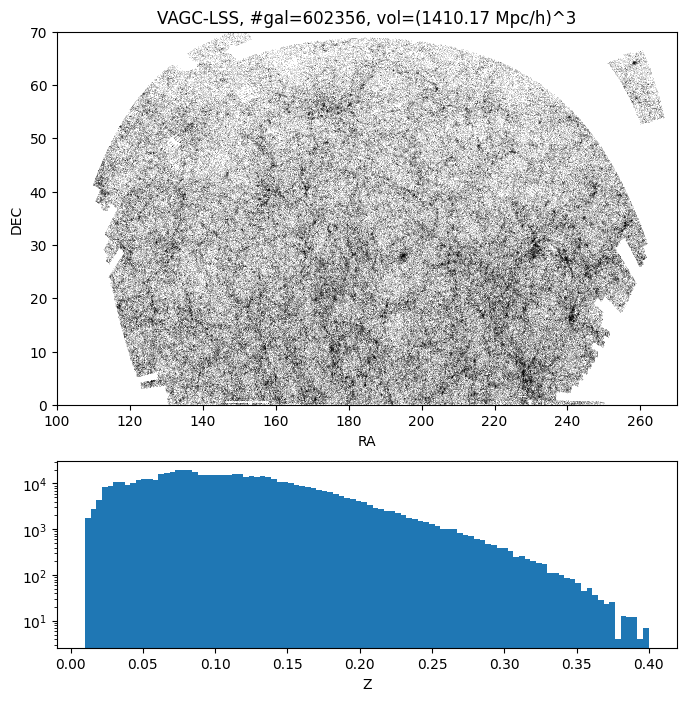

In [7]:
f = plt.figure(figsize=(8,8))
gs = f.add_gridspec(2,1, height_ratios=[1,0.5])

# vagc-lss
ax = f.add_subplot(gs[0])
ax.plot(data['RA'], data['DEC'], 'k,', alpha=0.1)
ax.set_xlim(rae)
ax.set_ylim(dece)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title(f'VAGC-LSS, #gal={len(data)}, vol=({dvol**(1/3):.2f} Mpc/h)^3')

ax = f.add_subplot(gs[1])
ax.hist(data['Z'], bins=100)
ax.set_xlabel('Z')
ax.semilogy()


Text(0.5, 0, 'Z')

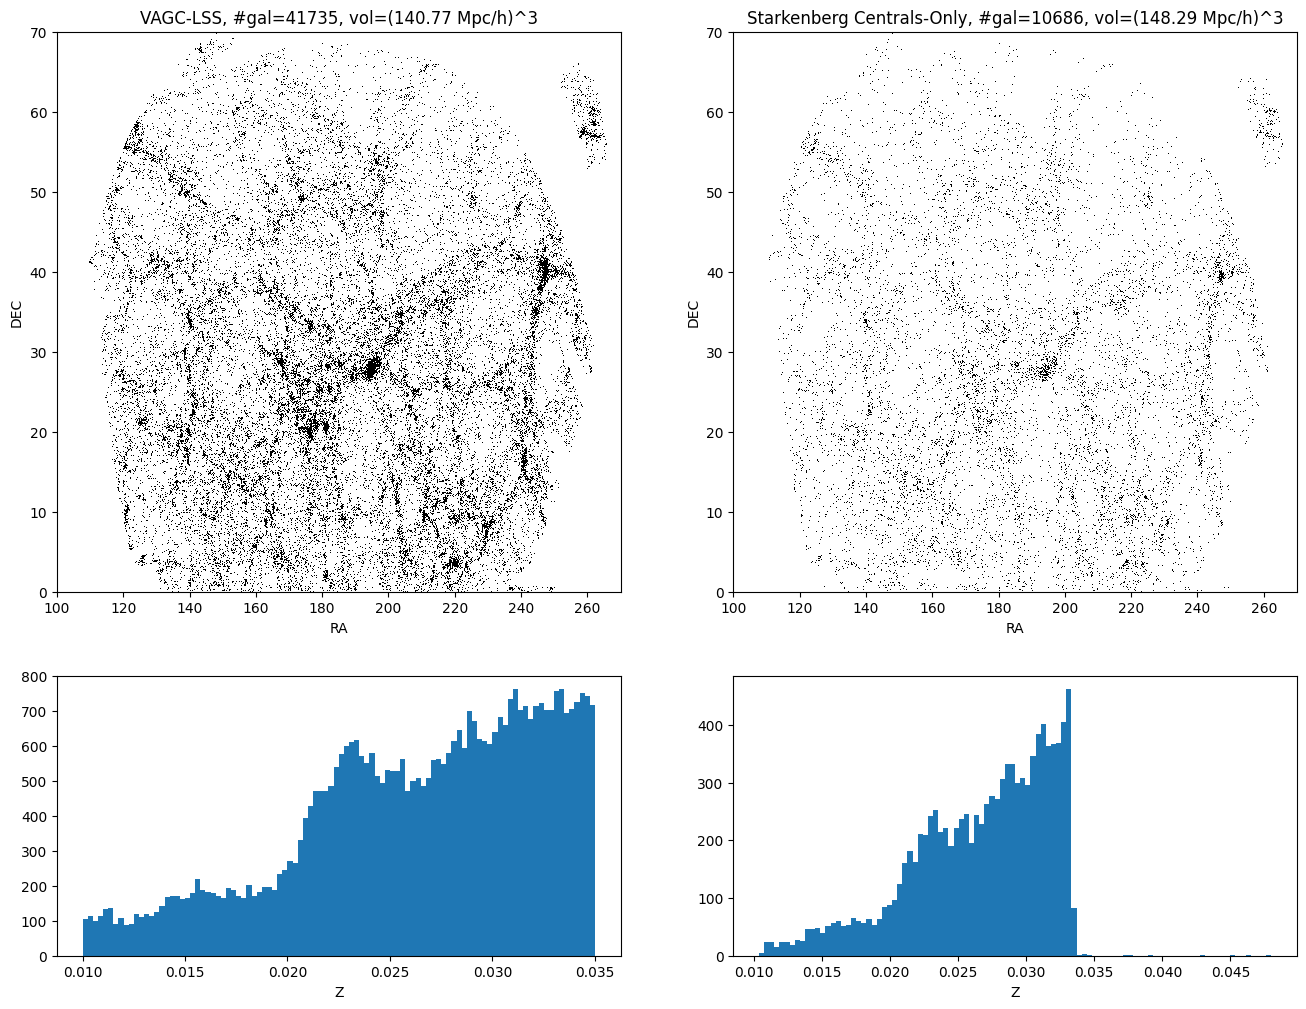

In [8]:
f = plt.figure(figsize=(16,12))
gs = f.add_gridspec(2,2, height_ratios=[1,0.5])

# vagc-lss
ax = f.add_subplot(gs[0,0])
ax.plot(data[tjmask]['RA'], data[tjmask]['DEC'], 'k,', alpha=1)
ax.set_xlim(rae)
ax.set_ylim(dece)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title(f'VAGC-LSS, #gal={len(data[tjmask])}, vol=({dmvol**(1/3):.2f} Mpc/h)^3')

ax = f.add_subplot(gs[1,0])
ax.hist(data[tjmask]['Z'], bins=100)
ax.set_xlabel('Z')
# ax.semilogy()

# tjitske
ax = f.add_subplot(gs[0,1])
ax.plot(datatj['RA'], datatj['DEC'], 'k,', alpha=1)
ax.set_xlim(rae)
ax.set_ylim(dece)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title(f'Starkenberg Centrals-Only, #gal={len(datatj)}, vol=({dtjvol**(1/3):.2f} Mpc/h)^3')

ax = f.add_subplot(gs[1,1])
ax.hist(datatj['Z'], bins=100)
ax.set_xlabel('Z')

Text(0, 0.5, 'M')

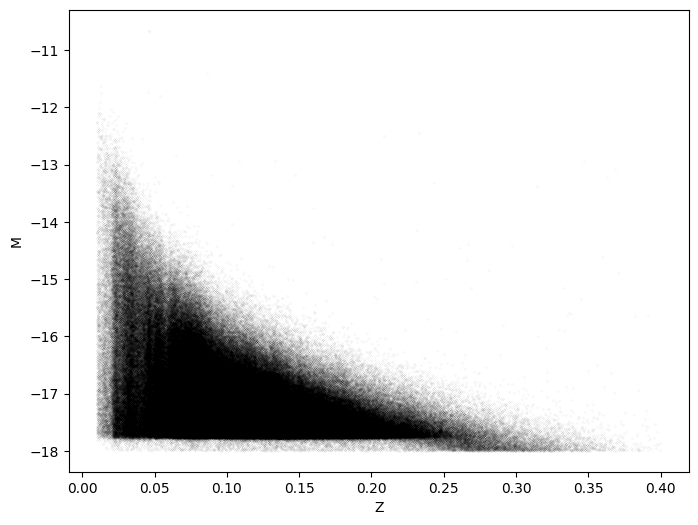

In [9]:
# plot magnitude-redshift distribution
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(data['Z'], -data['M'], 'k.', markersize=0.1, alpha=0.5)
ax.set_xlabel('Z')
ax.set_ylabel('M')

(-20.0, 150.0)

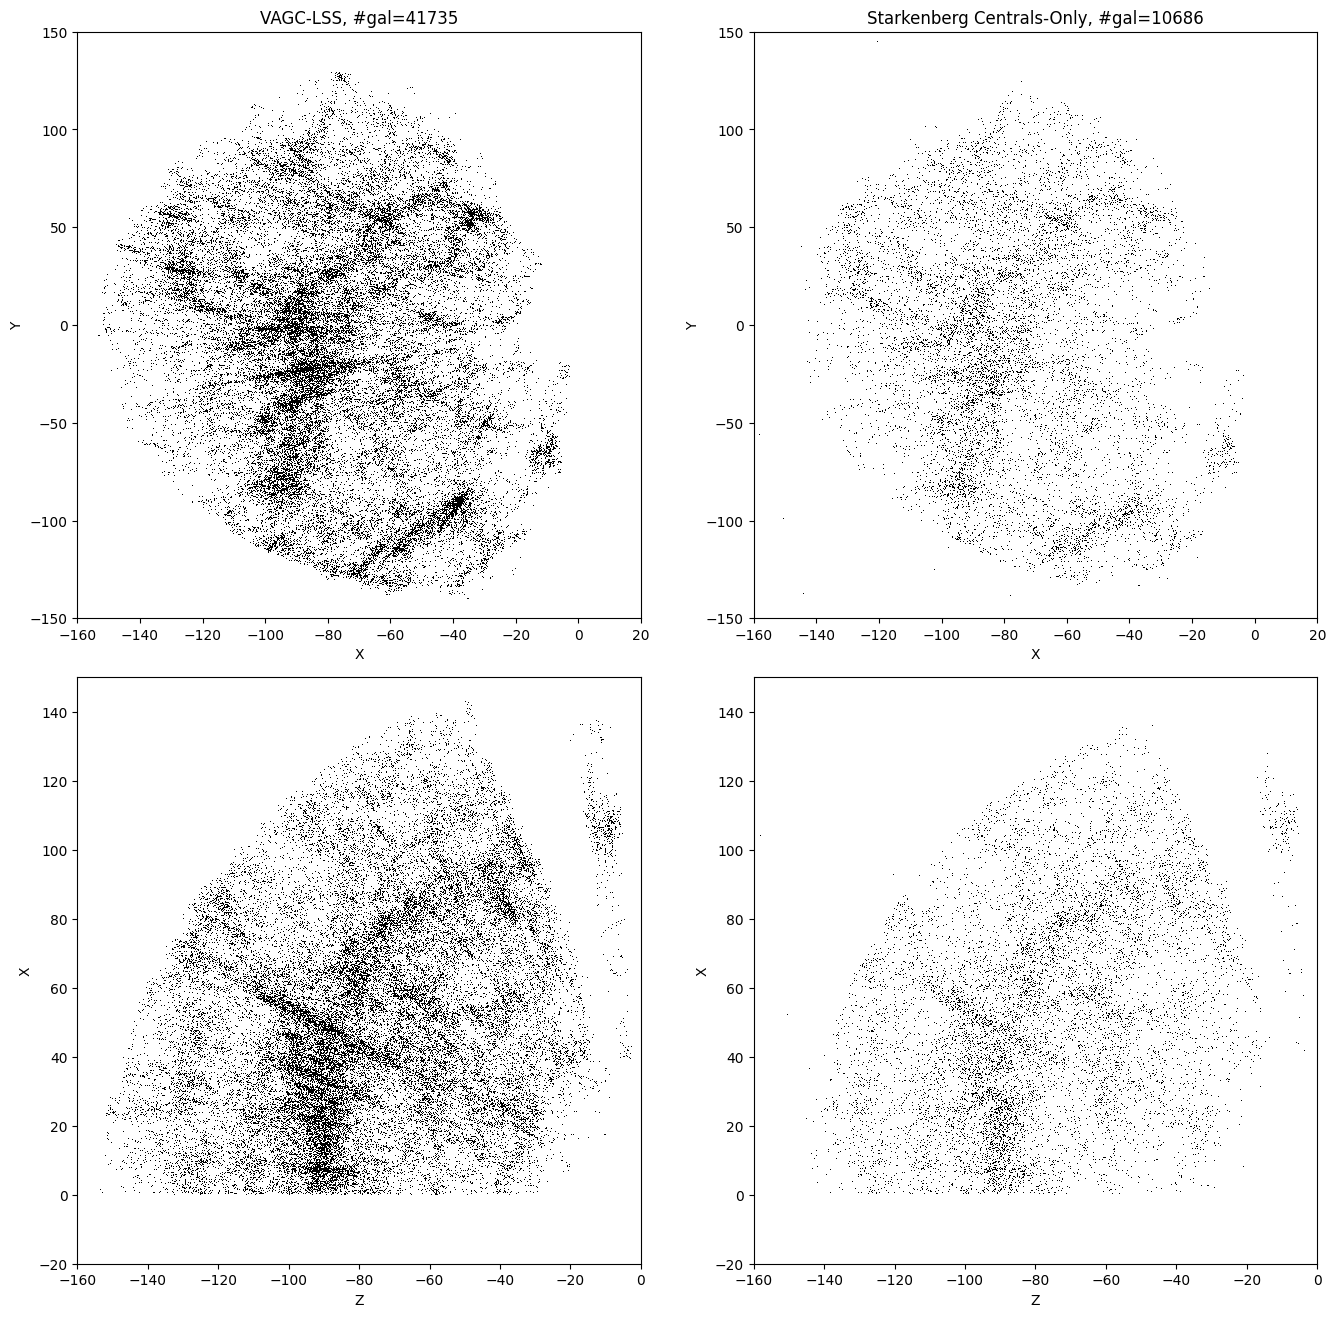

In [10]:
# plot comoving coordinates
f = plt.figure(figsize=(16,16))
gs = f.add_gridspec(2,2, height_ratios=[1,1], hspace=0.1)

# vagc-lss
ax = f.add_subplot(gs[0,0])
ax.plot(data[tjmask]['cX'], data[tjmask]['cY'], 'k,', alpha=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'VAGC-LSS, #gal={len(data[tjmask])}')
ax.set_xlim(-160, 20)
ax.set_ylim(-150, 150)

ax = f.add_subplot(gs[1,0])
ax.plot(data[tjmask]['cX'], data[tjmask]['cZ'], 'k,', alpha=1)
ax.set_xlabel('Z')
ax.set_ylabel('X')
ax.set_xlim(-160, 0)
ax.set_ylim(-20, 150)


# tjitske
ax = f.add_subplot(gs[0,1])
ax.plot(datatj['cX'], datatj['cY'], 'k,', alpha=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Starkenberg Centrals-Only, #gal={len(datatj)}')
ax.set_xlim(-160, 20)
ax.set_ylim(-150, 150)

ax = f.add_subplot(gs[1,1])
ax.plot(datatj['cX'], datatj['cZ'], 'k,', alpha=1)
ax.set_ylabel('X')
ax.set_xlabel('Z')
ax.set_xlim(-160, 0)
ax.set_ylim(-20, 150)



## divisez en quatre

In [11]:
ramid = 187
decmid = 30

def label_quadrants(dat):
    bins = np.zeros(len(dat))
    mask = (dat['RA']<ramid) & (dat['DEC']<decmid)
    bins[mask] = 0
    mask = (dat['RA']<ramid) & (dat['DEC']>decmid)
    bins[mask] = 1
    mask = (dat['RA']>ramid) & (dat['DEC']<decmid)
    bins[mask] = 2
    mask = (dat['RA']>ramid) & (dat['DEC']>decmid)
    bins[mask] = 3
    return bins

data['bin'] = label_quadrants(data)
datatj['bin'] = label_quadrants(datatj)

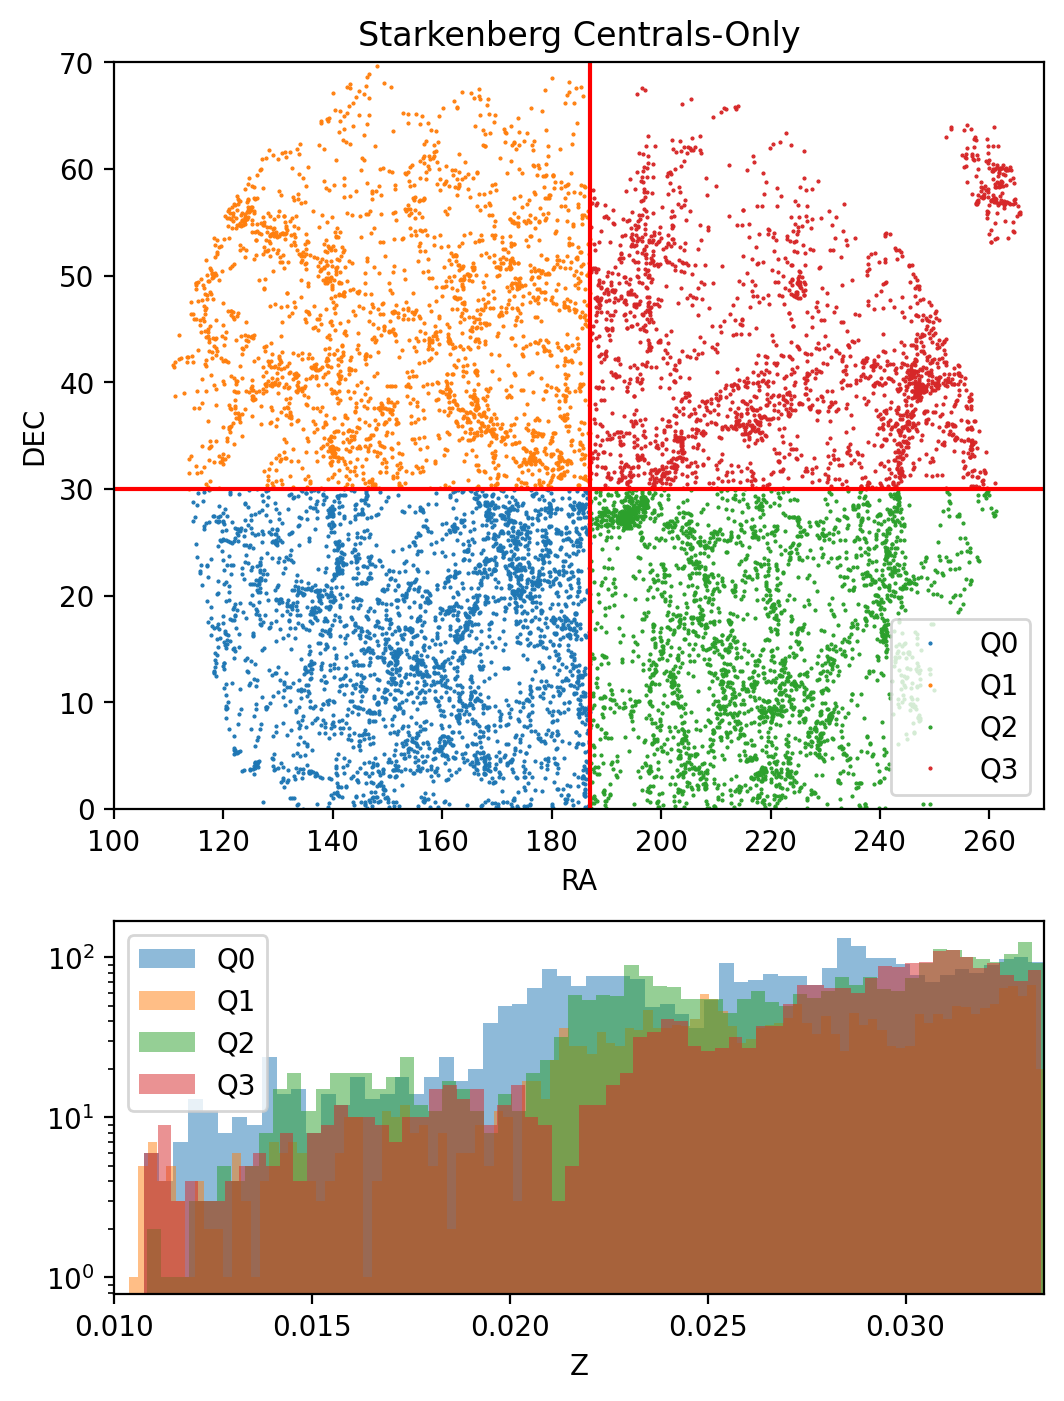

In [20]:
f = plt.figure(figsize=(6,8), dpi=200)
gs = f.add_gridspec(2,1, height_ratios=[1,0.5])

# tjitske
ax = f.add_subplot(gs[0])
for i in range(4):
    mask = datatj['bin'] == i
    ax.plot(datatj[mask]['RA'], datatj[mask]['DEC'], '.', markersize=1, label=f'Q{i}')
ax.legend()
ax.set_xlim(rae)
ax.set_ylim(dece)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title(f'Starkenberg Centrals-Only')
ax.axvline(ramid, color='r')
ax.axhline(decmid, color='r')

ax = f.add_subplot(gs[1])
for i in range(4):
    mask = datatj['bin'] == i
    ax.hist(datatj[mask]['Z'], bins=100, alpha=0.5, label=f'Q{i}')
ax.set_xlabel('Z')
ax.set_xlim(0.01, 0.0335)
ax.semilogy()
ax.legend();


In [13]:
# measure volume of each bin
for i in range(4):
    mask = datatj['bin'] == i
    vol = measure_volume(datatj['cX'][mask], datatj['cY'][mask], datatj['cZ'][mask])
    print(f'Q{i}: {np.sum(mask)} gals in ({vol**(1/3):.2f} Mpc/h)^3 = {np.sum(mask)/vol:.2e} gals/(Mpc/h)^3')

Q0: 3211 gals in (90.18 Mpc/h)^3 = 4.38e-03 gals/(Mpc/h)^3
Q1: 2381 gals in (79.31 Mpc/h)^3 = 4.77e-03 gals/(Mpc/h)^3
Q2: 2863 gals in (92.00 Mpc/h)^3 = 3.68e-03 gals/(Mpc/h)^3
Q3: 2231 gals in (86.07 Mpc/h)^3 = 3.50e-03 gals/(Mpc/h)^3


## Calculate and compare P(k)

In [14]:
# import randoms

filename = pjoin(wdir, 'random', 'lss_random-0.dr72.fits')
with fits.open(filename) as f:
    print(f.info())
    random = f[1].data

random = pd.DataFrame(np.array([random[col] for col in random.dtype.names]).T, 
                      columns=random.dtype.names)

Filename: ../MGS/random/lss_random-0.dr72.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     25   1962944R x 4C   [D, D, J, E]   


None


In [15]:
# cut randoms
mask = (rae[0] < random['RA']) & (random['RA'] < rae[1]) 
mask &= (dece[0] < random['DEC']) & (random['DEC'] < dece[1])
random = random[mask]

mask = np.random.choice(len(random), 10*len(datatj), replace=False)
random = random.iloc[mask]

In [16]:
h, be = np.histogram(datatj['Z'], bins=100)
random['ZBIN'] = np.random.choice(np.arange(len(h)), size=len(random), p=h/h.sum())
random['Z'] = np.random.uniform(be[random['ZBIN']], be[random['ZBIN']+1], size=len(random))

106860

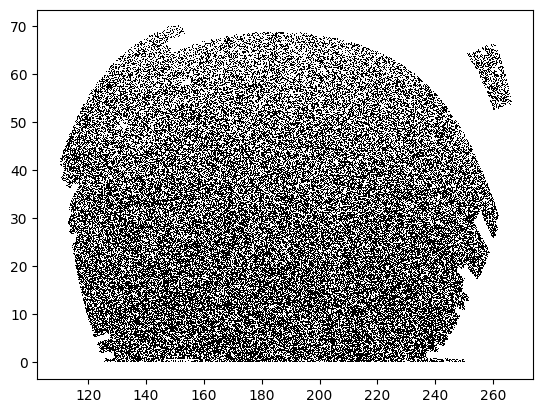

In [17]:
plt.plot(random['RA'], random['DEC'], 'k,', alpha=1)
len(random)

In [20]:
grdz = np.array([datatj['RA'], datatj['DEC'], datatj['Z']]).T
rrdz = np.array([random['RA'], random['DEC'], random['Z']]).T

In [21]:
from cmass.summaries.Pk import compute_Pk
from astropy.cosmology import Planck15

k, p0k, p2k, p4k = compute_Pk(grdz, rrdz, cosmo=Planck15)

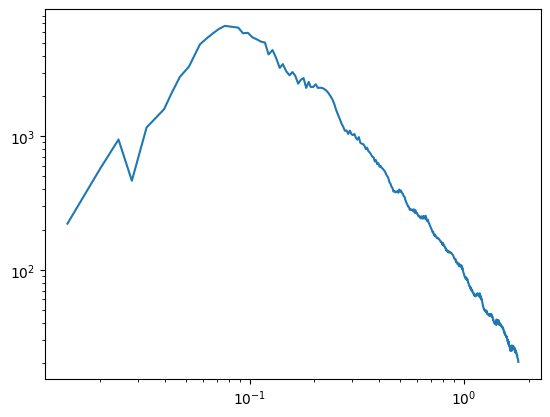

In [23]:
plt.loglog()
plt.plot(k, p0k)

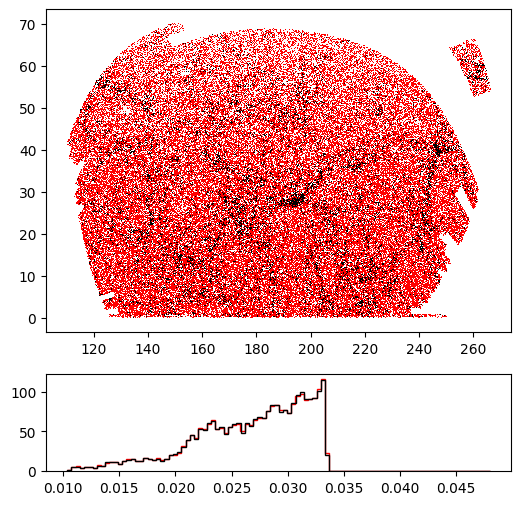

In [24]:
f, axs = plt.subplots(2, 1, figsize=(6,6), gridspec_kw={'height_ratios': [1, 0.3]})
axs[0].plot(rrdz[:,0], rrdz[:,1], 'r,', alpha=1)
axs[0].plot(grdz[:,0], grdz[:,1], 'k,', alpha=1)

axs[1].hist(rrdz[:,2], bins=100, histtype='step', color='r', density=True)
axs[1].hist(grdz[:,2], bins=100, histtype='step', color='k', density=True);

In [27]:
Pk0 = compute_Pk(grdz, rrdz, Planck15)

[Text(0.5, 0, 'k'), Text(0, 0.5, 'P2(k)')]

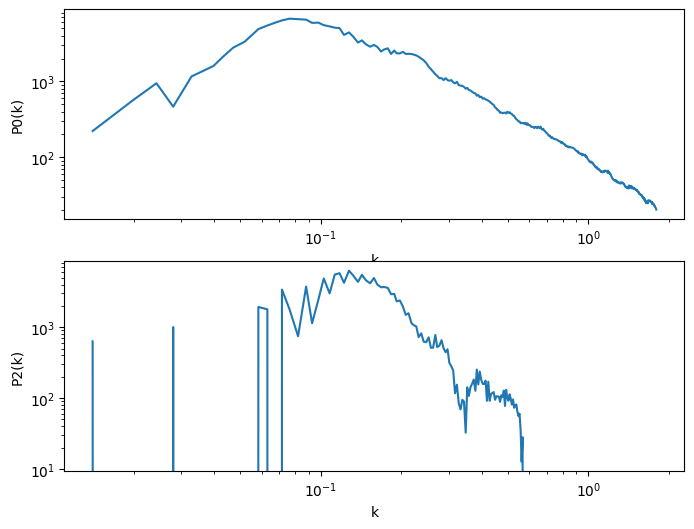

In [28]:
k, p0k, p2k = Pk0[:3]

f, axs = plt.subplots(2, 1, figsize=(8, 6))
axs[0].loglog()
axs[0].plot(k, p0k)
axs[0].set(xlabel='k', ylabel='P0(k)')

axs[1].loglog()
axs[1].plot(k, p2k)
axs[1].set(xlabel='k', ylabel='P2(k)')

## Calculate P(k) for quadrants

In [29]:
len(data), len(datatj), len(random)

(602356, 10686, 106860)

In [30]:
# data = datatj
data = data[tjmask]
data['bin'] = label_quadrants(data)
random['bin'] = label_quadrants(random)

In [51]:
kmin, kmax = 0, 4
Nmesh = 384

# all
grdz = np.array([data['RA'], data['DEC'], data['Z']]).T
rrdz = np.array([random['RA'], random['DEC'], random['Z']]).T
Pk0 = compute_Pk(grdz, rrdz, Planck15,
                 kmin=kmin, kmax=kmax, Ngrid=Nmesh)

In [52]:
Pks = []
for i in range(4):
    print(f'bin {i}')
    
    # galaxies
    mask = data['bin'] == i
    grdz = np.array([data[mask]['RA'], data[mask]['DEC'], data[mask]['Z']]).T

    # randoms
    mask = random['bin'] == i
    rrdz = np.array([random[mask]['RA'], random[mask]['DEC'], random[mask]['Z']]).T

    # relabel randoms
    h, be = np.histogram(grdz[:,2], bins=100)
    zbin = np.random.choice(np.arange(len(h)), size=len(rrdz), p=h/h.sum())
    rrdz[:,2] = np.random.uniform(be[zbin], be[zbin+1], size=len(rrdz))

    # calculate P(k)
    k, p0k, p2k, p4k = compute_Pk(
        grdz, rrdz, Planck15,
        kmin=kmin, kmax=kmax, Ngrid=Nmesh)
    Pks.append((k, p0k, p2k, p4k))

bin 0
bin 1
bin 2
bin 3


(0.05, 2)

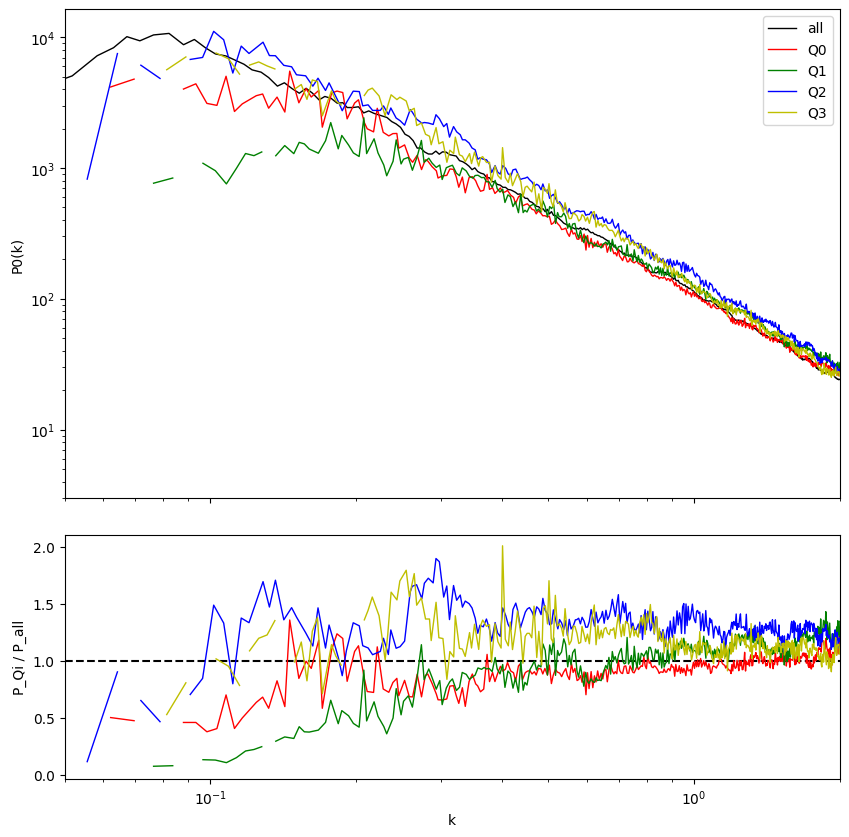

In [56]:
labels = ['all', 'Q0', 'Q1', 'Q2', 'Q3']
cs = ['k', 'r', 'g', 'b', 'y']

f, axs = plt.subplots(2,1, figsize=(10, 10), sharex=True,
                      gridspec_kw={'height_ratios':[1,0.5], 'hspace':0.1})

ax = axs[0]
for i, Pk in enumerate([Pk0]+Pks):
    ax.plot(Pk[0], Pk[1], label=labels[i], lw=1, color=cs[i])
ax.legend()
ax.loglog()
ax.set(ylabel='P0(k)')
ax.set_xlim(0.05, 2)


ax = axs[1]
ax.axhline(1, ls='--', c='k')
for i, Pk in enumerate(Pks):
    ax.plot(Pk[0], Pk[1]/Pk0[1], label=labels[i], lw=1, color=cs[i+1])

ax.set(xlabel='k', ylabel='P_Qi / P_all')
ax.set_xlim(0.05, 2)

## Prepare for Lucia and Tjitske

In [ ]:
# Load VAGC
with fits.open(pjoin(wdir, 'lss_index.dr72.fits')) as f:
    print(f.info())
    data = f[1].data

filename = pjoin(wdir, 'object_sdss_imaging.fits')
with fits.open(filename) as f:
    print(f.info())
    img = f[1].data

Filename: ../MGS/lss_index.dr72.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      10   ()      
  1                1 BinTableHDU     43   2506754R x 13C   [D, D, E, J, J, E, J, J, E, E, J, J, J]   
None
Filename: ../MGS/object_sdss_imaging.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    101   2506754R x 42C   [J, J, J, 3A, J, J, J, D, D, J, J, 5J, 5J, J, J, 5J, J, J, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, J, 5E, J, E, 5J, J, J, 5E, 5E, 5E, 5E, 5E]   
None


In [ ]:
rae = 100, 270
dece = 0, 70
ze = 0.01, 0.035
def in_range(data):
    mask = (rae[0] < data['RA']) & (data['RA'] < rae[1]) & (dece[0] < data['DEC']) & (data['DEC'] < dece[1])
    mask &= (ze[0] <= data['Z']) & (data['Z'] < ze[1])
    return mask

mask = (data['VAGC_SELECT'] == 7) & (data['ILSS'] != -1)
mask &= in_range(data)
data = data[mask]
img = img[mask]

print(len(data), len(img))

41735 41735


In [ ]:
from numpy.lib.recfunctions import rec_append_fields

to_add = list(data.dtype.names)
to_add.remove('RA')
to_add.remove('DEC')
to_add.remove('VAGC_SELECT')

img = rec_append_fields(img, to_add, 
                        data=[data[col] for col in to_add], 
                        dtypes=[data[col].dtype for col in to_add])

In [ ]:
np.save(pjoin(wdir, 'vagc_photlss_04042024.npy'), img)

(array([104., 114., 100., 114., 133., 137.,  92., 109.,  88.,  91., 118.,
        111., 119., 113., 126., 143., 169., 171., 172., 162., 164., 180.,
        220., 189., 182., 179., 171., 165., 193., 188., 171., 164., 201.,
        172., 183., 197., 197., 189., 234., 246., 272., 266., 331., 395.,
        427., 472., 471., 471., 485., 541., 578., 600., 612., 618., 572.,
        550., 579., 513., 494., 531., 529., 528., 563., 471., 501., 508.,
        485., 509., 560., 563., 549., 580., 613., 646., 593., 700., 672.,
        618., 616., 607., 640., 682., 659., 734., 763., 702., 715., 676.,
        714., 723., 703., 703., 758., 763., 695., 707., 727., 751., 744.,
        716.]),
 array([0.01000012, 0.01025011, 0.0105001 , 0.01075009, 0.01100009,
        0.01125008, 0.01150007, 0.01175006, 0.01200006, 0.01225005,
        0.01250004, 0.01275003, 0.01300002, 0.01325002, 0.01350001,
        0.01375   , 0.01399999, 0.01424999, 0.01449998, 0.01474997,
        0.01499996, 0.01524996, 0.01549995, 0.

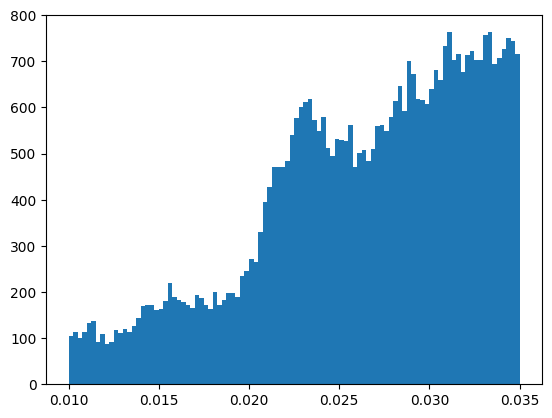

In [ ]:
plt.hist(img['Z'], bins=100)

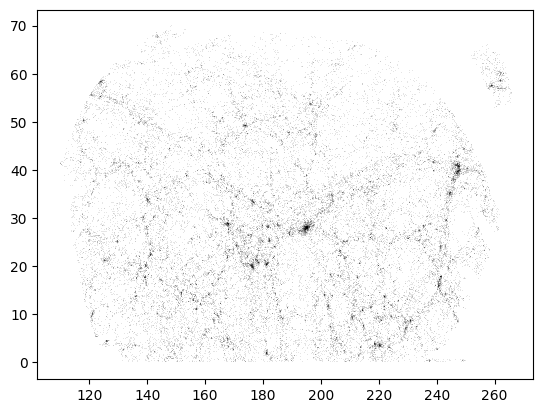

In [ ]:
plt.plot(img['RA'], img['DEC'], 'k,', alpha=0.1)

## VAGC angular mask

In [11]:
import pymangle
f_poly = pjoin(wdir, 'tmp_lss_geometry.ply')
mask = pymangle.Mangle(f_poly)

N=10000
ra = np.random.uniform(*rae, N)
dec = np.random.uniform(*dece, N)

In [8]:
area = np.sum(mask.areas * mask.weights)  # deg^2
area**.5

89.257262523414676904

In [12]:
w = mask.weight(ra, dec)

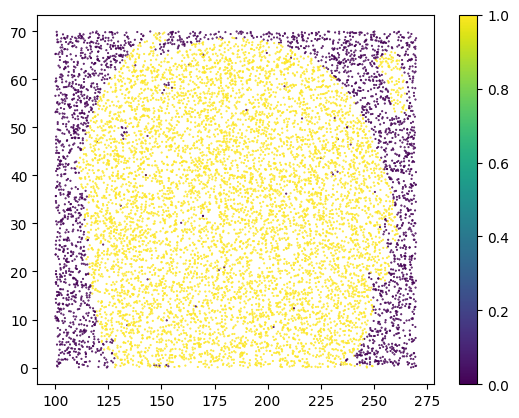

In [14]:
im = plt.scatter(ra, dec, c=w, marker='.', s=1)
plt.colorbar(im)

## Scratch

In [ ]:
rae, dece

((100, 270), (0, 70))